<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Change Detection Behavior + Optical Physiology </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 21, 2018</h3> 

<img src="../resources/change_detection_schematic.png" height="400" width="400">  


In [261]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');

# Import allensdk modules for loading and interacting with the data
from allensdk.internal.api import behavior_ophys_api as boa #TODO: We probably won't use this, but instead use the NWB api
from allensdk.brain_observatory.behavior import behavior_ophys_session as bos
import allensdk.brain_observatory.behavior.swdb.utilities as tools

from importlib import reload
reload(boa)
reload(bos)

<module 'allensdk.brain_observatory.behavior.behavior_ophys_session' from '/Users/alex.piet/allensdk/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_session.py'>

In [262]:
from allensdk.brain_observatory.behavior.swdb import behavior_project_cache as bpc

cache_json = {'manifest_path': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/visual_behavior_data_manifest.csv',
              'nwb_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/nwb_files',
              'analysis_files_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/extra_files_final'
              }
cache = bpc.BehaviorProjectCache(cache_json)
manifest = cache.manifest

In [263]:
experiment_id = 792812544
session = cache.get_session(experiment_id)

In [264]:
tr = session.trial_response_df


In [265]:
fr = session.flash_response_df

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Exercises</h2>

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Plot basic behavioral metrics over the session**

<p> 1) Plot the hit rate in a sliding window using the trial_response_dataframe.

<p> 2) Plot the false alarm rate in a sliding window

<p> 3) Plot the d` metric in a sliding window. 
    
<p> 4) What do you notice about this session?  How does the behavior influence how we should analyze the neural activity?

</div>

In [266]:
#define a sliding window to calculate teh hit rate, fa rate, and d-prime over
sliding_window=10

#first we extract the trials from the dataframe. Then we exclude aborted trials
trials=session.trials
trials=trials[trials.aborted==False]

#Re-index
trials=trials.reset_index(drop=True)

Text(0, 0.5, 'Hit Rate')

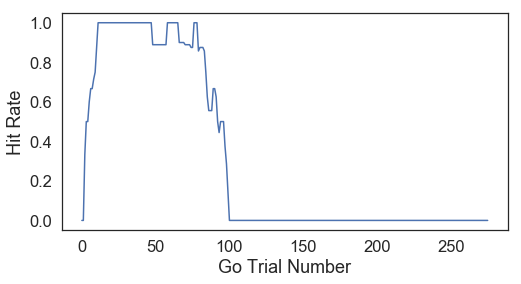

In [267]:
# SOLUTION
def calc_hit_rate(trials, sliding_window):
    
    #create empty arrays(pandas series) for go_responses and catch_responses to fill later
    go_responses = pd.Series([np.nan] * len(trials))      

    #encode true hits as one
    go_responses[trials.loc[(trials['go']==True) &(trials['hit']==True)].index]=1
    #encode misses on go trials as zero
    go_responses[trials.loc[(trials['go']==True) &(trials['hit']==False)].index]=0

    #note that after this, trials that are not GO are encoded as NaN in the go responses mask. We've excluded aborted
    return go_responses.rolling(window=sliding_window,min_periods=0).mean()#the hit rate

hit_rate=calc_hit_rate(trials,sliding_window=sliding_window)
fig, ax = plt.subplots(figsize=(8,4))

ax.plot (hit_rate)

ax.set_xlabel ('Go Trial Number')
ax.set_ylabel ('Hit Rate')

Text(0, 0.5, 'False Alarm Rate')

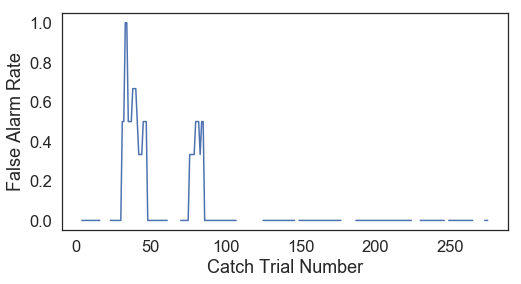

In [268]:
# SOLUTION
def calc_fa_rate(trials, sliding_window):
    catch_responses = pd.Series([np.nan] * len(trials))
    #false alarms are defined as responses on catch trials
    catch_responses[trials.loc[(trials['catch']==True) & (trials['false_alarm']==True)].index]=1
    catch_responses[trials.loc[(trials['catch']==True) & (trials['false_alarm']==False)].index]=0

    return catch_responses.rolling(window=sliding_window,min_periods=0).mean()

fa_rate= calc_fa_rate(trials,sliding_window=sliding_window)
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(fa_rate)

ax.set_xlabel ('Catch Trial Number')
ax.set_ylabel ('False Alarm Rate')

In [269]:
def dprime(hit_rate, fa_rate, limits=(0.01, 0.99)):
    
    from scipy.stats import norm
    """ calculates the d-prime for a given hit rate and false alarm rate
    https://en.wikipedia.org/wiki/Sensitivity_index
    Parameters
    ----------
    hit_rate : float
        rate of hits in the True class
    fa_rate : float
        rate of false alarms in the False class
    limits : tuple, optional
        limits on extreme values, which distort. default: (0.01,0.99)
    Returns
    -------
    d_prime
    """
    assert limits[0] > 0.0, 'limits[0] must be greater than 0.0'
    assert limits[1] < 1.0, 'limits[1] must be less than 1.0'
    #use Percent point function.
    #specifies the value of the variable such that the probability of the variable being less than or equal
    #to that value equals the given probability
    Z = norm.ppf

    # Limit values in order to avoid d' infinity
    hit_rate = np.clip(hit_rate, limits[0], limits[1])
    fa_rate = np.clip(fa_rate, limits[0], limits[1])

    return Z(hit_rate) - Z(fa_rate)

/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1914: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1914: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


Text(0, 0.5, 'D-Prime')

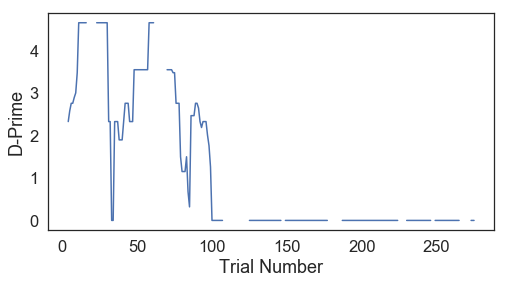

In [270]:
# SOLUTION
d_prime=dprime(hit_rate, fa_rate)

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(d_prime)

ax.set_xlabel ('Trial Number')
ax.set_ylabel ('D-Prime')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Plot the reaction time for hit trials**

<p> Plot the reaction time over the session. The reaction time is how long it takes for the mouse to lick on hit trials. 

</div>

Text(0, 0.5, 'Reaction Time (ms)')

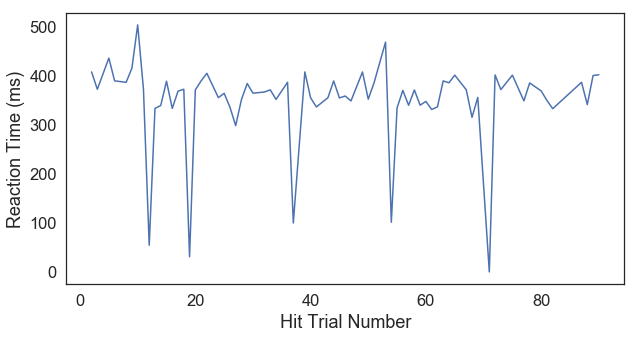

In [271]:
# SOLUTION
first_licks=[lick[0] for lick in trials.loc[(trials['go']==True) &(trials['hit']==True)]['lick_times']]

change_times=trials.loc[(trials['go']==True) &(trials['hit']==True)].change_time

reaction_time=first_licks-change_times
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(reaction_time*1000)

ax.set_xlabel ('Hit Trial Number')
ax.set_ylabel ('Reaction Time (ms)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Plot the hit rate transition matrix**

The task cycles through 8 different images. Some transitions (A-B) might be easier for the mouse to detect. Plot the hit transition matrix as a heatmap. On each axis should be the image name. 

</div>

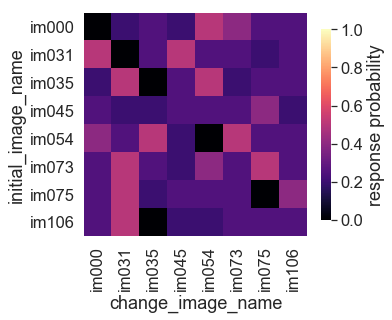

In [272]:
# SOLUTION
trials['response_latency_binary'] = [1 if response_latency<0.75 else 0 for response_latency in trials.response_latency.values]
trials['response_binary'] = [1 if np.isnan(response_time)==False else 0 for response_time in trials.response_latency.values]
response_matrix = pd.pivot_table(trials,  
                                 values='response_latency_binary', 
                                 index=['initial_image_name'],
                                 columns=['change_image_name'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(response_matrix, cmap='magma', square=True, annot=False,
            annot_kws={"fontsize": 10}, vmin=0, vmax=1,
            robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Single Cell Physiology Exercises</h2>

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Find maximally responsive cells**

<p> 1) Which trial evoked the largest response? Which cell had the largest response during the trial? Plot the df/f for that cell on that trial. Plot the change time. What type of trial was it, a go or catch trial?

<p> 2) Plot the average df/f for that cell for all trials of that image. The 'get_mean_df()' function can be useful here.
    
<p> 3) Plot the average df/f for that cell for each different image
    

</div>

Cell id: 914994919
Trial id: 370
Go trial: True
Catch trial: False
Change image: im106


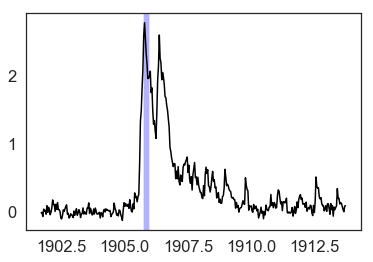

In [273]:
# Solution
max_cell_trial = tr.loc[tr.mean_response.idxmax()]
cell_id,trial_id = tr.mean_response.idxmax()
print('Cell id: ' + str(cell_id))
print('Trial id: ' + str(trial_id))
print('Go trial: ' + str(max_cell_trial.go))
print('Catch trial: ' + str(max_cell_trial.catch))
print('Change image: ' + str(max_cell_trial.change_image_name))
change_image = max_cell_trial.change_image_name
plt.plot(max_cell_trial.dff_trace_timestamps, max_cell_trial.dff_trace,'k-')
plt.axvspan(max_cell_trial.change_time, max_cell_trial.change_time + 0.25 ,alpha=0.3,facecolor='blue')

Text(0.5, 0, 'Time from change (s)')

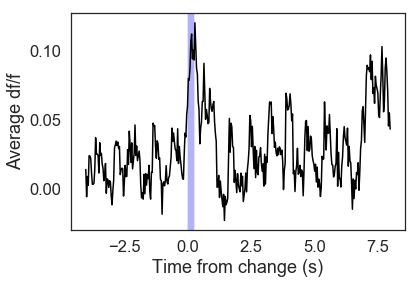

In [274]:
# SOLUTION
# Plot average df/f
mfr = tools.get_mean_df(session.trial_response_df,conditions=['cell_specimen_id','change_image_name'])
mfr = mfr.reset_index()
mfr = mfr.set_index(['cell_specimen_id','change_image_name'])
average_dff = mfr.loc[(cell_id,change_image)].mean_trace
timestamps = tr.iloc[0].dff_trace_timestamps  - tr.iloc[0].change_time
plt.plot(timestamps,average_dff,'k')
plt.axvspan(0, 0.25 ,alpha=0.3,facecolor='blue')
plt.ylabel('Average df/f')
plt.xlabel('Time from change (s)')

Text(0.5, 0, 'Time from change (s)')

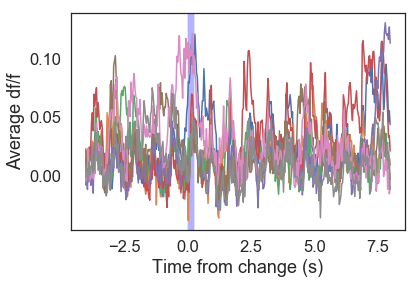

In [275]:
# SOLUTION
unique_images = tr.change_image_name.unique()
for image in unique_images:
    average_dff = mfr.loc[(cell_id,image)].mean_trace
    plt.plot(timestamps, average_dff)
plt.axvspan(0, 0.25 ,alpha=0.3,facecolor='blue')
plt.ylabel('Average df/f')
plt.xlabel('Time from change (s)')


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Compute trial averaged response for all cells **

<p> 1) Compute a `heat map` image that shows each cell's average response across all trials

<p> 2) What structure do you see in this population? Sorting the cells can help see structure.

</div>

In [276]:
# SOLUTION
mfr = tools.get_mean_df(tr,conditions=['cell_specimen_id'])
heatmap = mfr.mean_trace.values
heatmap = np.stack(heatmap,axis=0)
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time

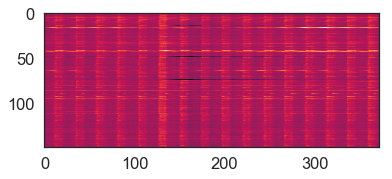

In [277]:
plt.imshow(heatmap)

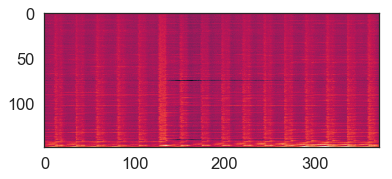

In [278]:
x = np.argsort(np.max(heatmap,1))
heatmap_sorted = heatmap[x,:]
plt.imshow(heatmap_sorted)

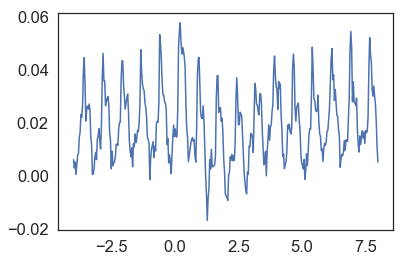

In [279]:
plt.plot(timestamps,heatmap_sorted[100,:])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Plot the cell's' trial averaged response for go and catch trials**

<p>1) For your cell, plot the average trial response for all images on go trials

<p>2) Repeat for 'catch' trials. How is the response different than on 'go' trials? 
</div>

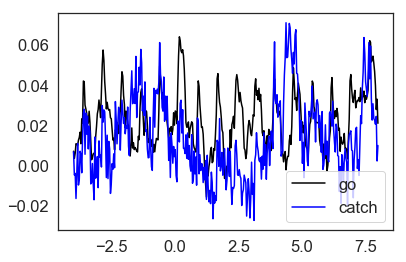

In [280]:
# SOLUTION
df_go = tr[tr.go]
df_catch = tr[tr.catch]

mfr_go = tools.get_mean_df(df_go,conditions=['cell_specimen_id'])
mfr_go = mfr_go.set_index('cell_specimen_id')
average_go = mfr_go.loc[cell_id].mean_trace
mfr_catch = tools.get_mean_df(df_catch,conditions=['cell_specimen_id'])
mfr_catch = mfr_catch.set_index('cell_specimen_id')
average_catch = mfr_catch.loc[cell_id].mean_trace

plt.plot(timestamps, average_go, 'k',label='go')
plt.plot(timestamps, average_catch, 'b',label='catch')
plt.legend()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Plot an image tuning curve for responses to the first flash after a change on 'go' trials**

<p>1) Filter `trial_response_df` to select only 'go' trials and assign to a variable called `df`. The `mean_response` column of the `trial_response_df` is the mean of the dF/F trace in a 500ms window after the change time for that trial.



<p>2) Loop through each `change_image_name` in `df.change_image_name.unique()` and get the values of the `mean_response` column for your `cell`.



<p>3) Take the average and SEM of the `mean_response` values for each `change_image_name` and plot a tuning curve. Hint: use `from scipy.stats import sem` to get a function to compute the standard error. 



<p>4) Save the averaged response to each image as an array called 'image_responses'.
</div>

In [281]:
df_go = tr[tr.go]

In [282]:
mfr_go = tools.get_mean_df(df_go,conditions=['cell_specimen_id','change_image_name'])
mfr_go = mfr_go.set_index(['cell_specimen_id','change_image_name'])
images = np.array(mfr_go.index.get_level_values(1).unique())

Text(0, 0.5, 'Average df/f')

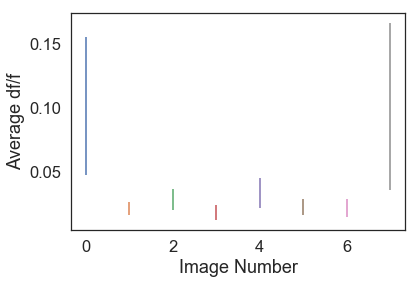

In [283]:
image_responses =[]
for i,image in  enumerate(images):
    cell_image = mfr_go.loc[(cell_id,image)]
    plt.errorbar(i,cell_image.mean_response, yerr=cell_image.sem_response)
    image_responses.append(cell_image.mean_response)
plt.xlabel('Image Number')
plt.ylabel('Average df/f')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Computing lifetime sparseness </h2>
<p>'lifetime sparseness' is a metric for how selective and sparse a cell's activity is across conditions, bounded between 0 and 1. A high value of this metric indicates high selectivity - a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions. 

<p>We will compute this metric for single cells and take the mean across the population. Before taking the mean, we will filter out cells that do not have a signficant image response.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Compute lifetime sparseness using the mean image response on 'go' trials for your cell**
<p>1) Provide the array of `image_responses` created in Exercise 5.9 to the function below to compute the lifetime sparseness metric for your cell. How selective is this cell? 
    
<p>2) Using the average trial response you generated before for all cells, compute the spareness over flashes in each trial. Do some cells respond evenly across the trial, or do other modulate their responses?
</div>

In [284]:
def compute_lifetime_sparseness(image_responses):
    # image responses should be an array of the trial averaged responses to each image
    # sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
    # N = number of images
    # after Vinje & Gallant, 2000; Froudarakis et al., 2014
    N = float(len(image_responses))
    ls = ((1-(1/N) * ((np.power(image_responses.sum(axis=0),2)) / (np.power(image_responses,2).sum(axis=0)))) / (1-(1/N)))
    return ls

In [285]:
# SOLUTION
ls = compute_lifetime_sparseness(np.array(image_responses))
print(ls)

0.4330109238913455


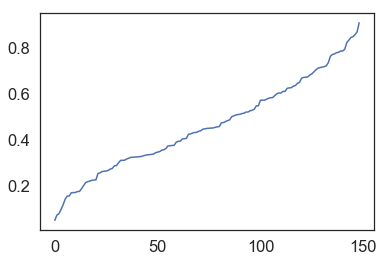

In [286]:
# SOLUTION
ls = compute_lifetime_sparseness(heatmap.T)
plt.plot(np.sort(ls))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Identify cells with a significant image response**
<p>The `p_value` column of the `flash_response_df` is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms after the flash with the activity during the spontaneous activity period. 

<p>Let's define responsive cells as having at least 10% of trials with a p_value < 0.005

<p>1) Loop through all cells, evaluate the fraction of trials with p_value < 0.005 and make a list of the indicies of responsive cells. Assign the list to a variable called `responsive_cells`.

<p>What fraction of cells in this experiment were responsive following a stimulus change? 

</div>

In [287]:
# SOLUTION 
mean_fr = tools.get_mean_df(fr, conditions=['cell_specimen_id'],flashes=True)
responsive_cells = mean_fr[mean_fr.fraction_significant_responses>.1].cell_specimen_id

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise: Get the mean lifetime sparseness across  responsive cells** 

<p>1) Loop through each cell in `responsive_cells`, compute lifetime sparseness as you did above, and add the value to a list. 

<p>2) Convert the list to an array and take the mean.

</div>

In [288]:
# SOLUTION 
all_ls= []
# Get a dataframe of each cell/image pair, which computes a mean_response
mean_fr = tools.get_mean_df(fr, conditions=['cell_specimen_id','image_name'])
mean_fr = mean_fr.set_index(['cell_specimen_id','image_name'])

# Iterate through the responsive cells, and compute lifetime sparseness
for cell in responsive_cells:
    image_responses =[]
    for i,image in  enumerate(images):
        cell_image = mean_fr.loc[(cell,image)]
        image_responses.append(cell_image.mean_response)        
    ls = compute_lifetime_sparseness(np.array(image_responses))
    all_ls.append(ls)
    

In [289]:
all_ls = np.array(all_ls)
np.mean(all_ls)

0.45214428480476015

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Across Session Neural Physiology Exercises</h2>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
One interesting aspect of this dataset is multiple behavior and ophys sessions from each animal. In some cases we might want to perform analyses that compare multiple sessions across the same container to know how behavior or neural responses change with each stage of the task.     

</div>

In [290]:
manifest = cache.manifest
manifest.head(15)[['container_id','stage_name','ophys_experiment_id']]

,container_id,stage_name,ophys_experiment_id
127,782536745,OPHYS_2_images_A_passive,775614751
169,782536745,OPHYS_2_images_A_passive,778644591
171,782536745,OPHYS_2_images_A_passive,788490510
159,782536745,OPHYS_4_images_B,792812544
180,782536745,OPHYS_5_images_B_passive,796106850
200,791352433,OPHYS_1_images_A,792815735
225,791352433,OPHYS_2_images_A_passive,798404219
227,791352433,OPHYS_3_images_A,795073741
228,791352433,OPHYS_4_images_B,795953296
202,791352433,OPHYS_5_images_B_passive,796108483


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
From there, we can select two experiment dataframes we wish to analyze from the same container.
</div>

In [291]:
#an active, image_set A dataset
a_trials=cache.get_session(792815735).trials
#an active, image_set B dataset
b_trials=cache.get_session(795953296).trials

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We can compare many metrics between these two sessions, as an example, the hit rate between each session using code developed above
</div>

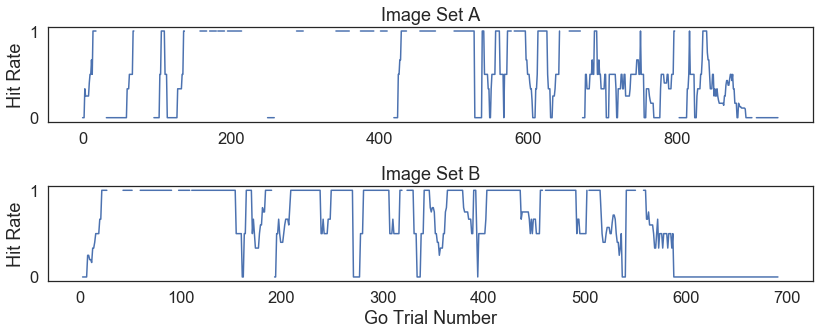

In [292]:
fig, axarr = plt.subplots(2,figsize=(12,5))

axarr[0].plot (calc_hit_rate(a_trials,sliding_window=sliding_window))
axarr[0].set_title('Image Set A')
axarr[0].set_ylabel ('Hit Rate')

axarr[1].plot (calc_hit_rate(b_trials,sliding_window=sliding_window))
axarr[1].set_xlabel ('Go Trial Number')
axarr[1].set_title('Image Set B')
axarr[1].set_ylabel ('Hit Rate');
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
For more in-depth analysis and to ease plotting, we can merge the two dataframes, passing keys to keep their labels
</div>

In [293]:
a_b=pd.concat([a_trials,b_trials], keys=['a', 'b'])
a_b.head()

initial_image_name change_image_name  change_time  \
  trials_id                                                     
a 0                      im065             im085   310.570650   
  1                      im085             im085          NaN   
  2                      im085             im065   325.584116   
  3                      im065             im063   338.343687   
  4                      im063             im061   350.353097   

                                                    lick_times  \
  trials_id                                                      
a 0                                                         []   
  1                                     [319.49318, 319.66359]   
  2                                                         []   
  3                                                [338.51413]   
  4          [351.25191, 351.72162, 351.87257, 352.00235, 3...   

             response_latency  reward_time     go  catch    hit   miss  \
  trials_id                                                              
a 0                       inf          NaN   True  False  False   True   
  1                       NaN          NaN  False  False  False  False   
  2                       inf          NaN   True  False  False   True   
  3                  0.174502   338.518211   True  False   True  False   
  4                       inf          NaN   True  False  False   True   

             false_alarm  correct_reject  aborted  auto_rewarded  \
  trials_id                                                        
a 0                False           False    False          False   
  1                False           False     True          False   
  2                False           False    False          False   
  3                False           False    False          False   
  4                False           False    False          False   

             reward_volume  start_time   stop_time  trial_length  reward_rate  
  trials_id                                                                    
a 0                  0.000  306.817255  314.840549      8.023294          inf  
  1                  0.000  315.074047  319.977837      4.903791          inf  
  2                  0.000  320.328342  329.852679      9.524337          inf  
  3                  0.007  330.086130  342.613727     12.527597          inf  
  4                  0.000  342.846806  354.622994     11.776188          inf

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
note that looking at the tail lets you see the b trial dataframe that was just merged
</div>

In [294]:
a_b.tail()

initial_image_name change_image_name  change_time lick_times  \
  trials_id                                                                
b 687                    im054             im045  3870.105960         []   
  688                    im045             im031  3877.611752         []   
  689                    im031             im035  3886.619153         []   
  690                    im035             im035  3894.875444         []   
  691                    im035             im106  3907.636363         []   

             response_latency  reward_time     go  catch    hit   miss  \
  trials_id                                                              
b 687                     inf          NaN   True  False  False   True   
  688                     inf          NaN   True  False  False   True   
  689                     inf          NaN   True  False  False   True   
  690                     inf          NaN  False   True  False  False   
  691                     inf          NaN   True  False  False   True   

             false_alarm  correct_reject  aborted  auto_rewarded  \
  trials_id                                                        
b 687              False           False    False          False   
  688              False           False    False          False   
  689              False           False    False          False   
  690              False            True    False          False   
  691              False           False    False          False   

             reward_volume   start_time    stop_time  trial_length  \
  trials_id                                                          
b 687                  0.0  3866.352623  3874.359333      8.006711   
  688                  0.0  3874.609568  3881.865087      7.255519   
  689                  0.0  3882.115139  3890.872341      8.757202   
  690                  0.0  3891.122527  3899.129105      8.006578   
  691                  0.0  3899.379964  3911.889530     12.509566   

             reward_rate  
  trials_id               
b 687           0.242226  
  688           0.250578  
  689           0.260373  
  690           0.269140  
  691           0.279492

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
we can calculate simple metrics by grouping by the index. In a multi-index dataframe, these can be referenced by their level
</div>

In [295]:
a_b.groupby(level=0).trial_length.mean()

a    3.483137
b    4.857876
Name: trial_length, dtype: float64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
we can also quickly plot metrics across the two sessions
</div>

Text(0.5, 0, 'Image_set')

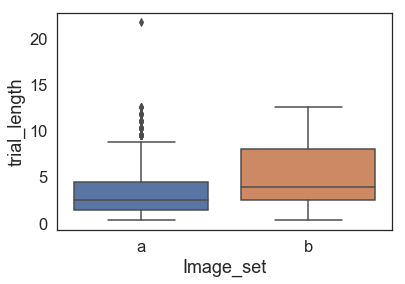

In [296]:
ax = sns.boxplot(data=a_b.reset_index(),x='level_0', y='trial_length')
ax.set_xlabel('Image_set')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
we can also get an idea if there are different distributions of trials, in this instance hit trials
</div>

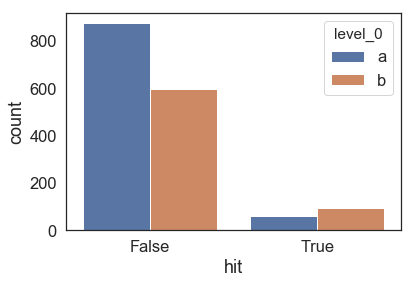

In [297]:
sns.countplot(data=a_b.reset_index()[['level_0','hit']],x='hit',hue='level_0')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
**Exercise: Perform comparisons across sessions within the same container to see how mouse behavior or the cellular responses change with each stage of the task **
   
<p> 1) Compare a behavorial metric between an image set A session and image set B session (active). One option is to use the trials dataframe 

<p> 2) Compare a cellular response metric (physiology) between an active session and a passive session for the same image type (A, for example). 

<p> 3) Are there potential interesting differences between the session types?


</div>

/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1166: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/Users/alex.piet/miniconda3/envs/SWDB/lib/python3.6/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Text(0.5, 0, 'Image_set')

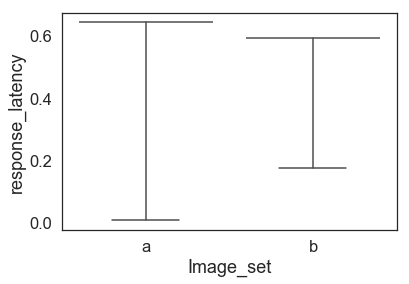

In [298]:
# Solution is to change the example code above to use something other than 'trial_length'
ax = sns.boxplot(data=a_b.reset_index(),x='level_0', y='response_latency')
ax.set_xlabel('Image_set')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
A more robust way to merge across sessions is to use the create_multi_session_mean_df() function.   

</div>

In [299]:
#an active, image_set A dataset
session_a=cache.get_session(792815735)
#an active, image_set B dataset
session_b=cache.get_session(795953296)
sessions = [session_a,session_b]
mega_trial_mdf = tools.create_multi_session_mean_df(manifest, sessions)
mega_flash_mdf = tools.create_multi_session_mean_df(manifest, sessions, flashes=True, conditions=['cell_specimen_id','image_name'])



792815735
795953296
792815735
795953296


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
By using the groupby() command you can quickly generate comparisons of the same cells across sessions
</div>

In [300]:
mega_flash_mdf.groupby(['cell_specimen_id','experiment_id']).mean_response.mean()

cell_specimen_id  experiment_id
817101771         792815735        0.008152
                  795953296        0.024764
817102086         792815735        0.004620
                  795953296        0.056666
817102331         792815735        0.010899
                  795953296        0.130632
817102690         795953296        0.015660
817103270         792815735        0.002695
                  795953296        0.007369
817103488         792815735        0.003650
817103554         792815735        0.027767
                  795953296        0.065774
817103649         792815735        0.003291
817103700         792815735        0.046298
                  795953296        0.071480
817103780         792815735        0.003729
                  795953296        0.008241
817103819         792815735        0.006092
                  795953296        0.058278
817103880         792815735        0.003766
817103916         792815735        0.006863
817103993         792815735        0.005187


<iv style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Using the unstack() command you can regroup these values by cell
    
<p> 1) How can you tell if a cell was identified in both sessions?
</div>

In [301]:
cell_exp_mean = mega_flash_mdf.groupby(['cell_specimen_id','experiment_id']).mean_response.mean()
cell_exp_mean.unstack(level=-1).head()

experiment_id,792815735,795953296
cell_specimen_id,,
817101771,0.008152,0.024764
817102086,0.004620,0.056666
817102331,0.010899,0.130632
817102690,NaN,0.015660
817103270,0.002695,0.007369


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
If the function you want to apply after the groupby() command operates on something other than a numeric value, you might need to use the .apply(<function>) command
</div>

In [302]:
mean_trace = mega_flash_mdf.groupby(['cell_specimen_id','experiment_id']).mean_trace.apply(np.mean)

In [303]:
mean_trace = mean_trace.unstack(level=-1)

In [304]:
mean_trace.head()

experiment_id,792815735,795953296
cell_specimen_id,,
817101771,"[0.004940688938934392, 0.0037827500025543904, ...","[0.1075000448103635, 0.10331776640214624, 0.09..."
817102086,"[0.0028651400834949184, 0.004510286147274358, ...","[0.07442738986406898, 0.06730318589559263, 0.0..."
817102331,"[0.009569138227520603, 0.010855333387398193, 0...","[0.20046691232407685, 0.19520988753310284, 0.1..."
817102690,NaN,"[0.08446222276299874, 0.07857994094298576, 0.0..."
817103270,"[0.0011548817350684993, 0.0013426018825934338,...","[0.015957100668488898, 0.014240873940175112, 0..."


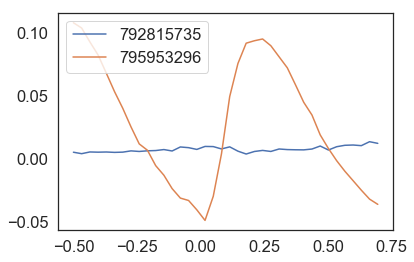

In [305]:
cell = mean_trace.iloc[0]
# hacky way to get timestamps for now
flash_timestamps = sessions[0].flash_response_df.iloc[0].dff_trace_timestamps
flash_timestamps -= flash_timestamps[0] 
flash_timestamps -=0.5
for id in cell.keys():
    plt.plot(flash_timestamps, cell[id],label=str(id))
plt.legend()


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
**Exercise - Merge all the experiments from a single container and plot the mean trial response across all cells for each session**    
    
<p> 1) Get all experiment_ids for a single container_id

<p> 2) Get all session objects for those experiments

<p> 3) Merge the trial_response_dfs for each session using 'create_multi_session_mean_df'
    
<p> 4) Use the groupby() command to select relevent properties
</div>

In [253]:
# SOLUTION
exp_ids = manifest[manifest.container_id == 803516615].ophys_experiment_id.values
container_sessions=[]
for id in exp_ids:
    try:
        container_sessions.append(cache.get_session(id))
        print(container_sessions[-1].metadata['ophys_experiment_id'])
    except:
        print('crash')
    

822024770
822641265
823392290
825120601
825623170
826585773


In [186]:
# Slow to run on wifi until the trial_response_dfs are loaded
container_trial_mdf = tools.create_multi_session_mean_df(manifest, container_sessions)

822024770
822641265
823392290
825120601
825623170
826585773


In [306]:
container_trial_mdf.groupby(['experiment_id','stage_name']).mean_response.mean()

experiment_id  stage_name              
822024770      OPHYS_1_images_A            0.025983
822641265      OPHYS_2_images_A_passive    0.034936
823392290      OPHYS_3_images_A            0.032220
825120601      OPHYS_4_images_B            0.049099
825623170      OPHYS_5_images_B_passive    0.042230
826585773      OPHYS_6_images_B            0.038601
Name: mean_response, dtype: float64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
**Exercise - Plot the average response across image set A vs image set B sessions**    
    

</div>

In [307]:
# Solution across all cells averaged together
container_trial_mdf.groupby('image_set').mean_response.mean()


image_set
A    0.031079
B    0.043137
Name: mean_response, dtype: float64

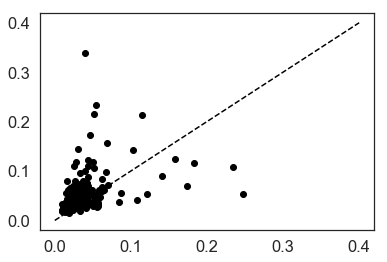

In [308]:
# On a per-cell basis
cell_image = container_trial_mdf.groupby(['cell_specimen_id','image_set']).mean_response.mean().unstack(level=1)
plt.plot(cell_image.values[:,0],cell_image.values[:,1],'ko')
plt.plot([0,0.4],[0,0.4],'k--')


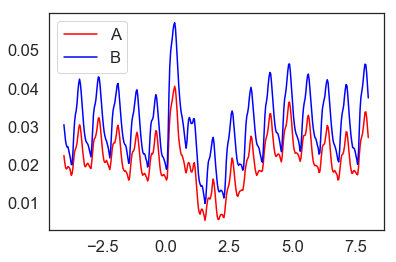

In [309]:
# plot the Average trace for all cells by image_set
image_set_trace= container_trial_mdf.groupby('image_set').mean_trace.apply(np.mean)
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
plt.plot(timestamps, image_set_trace.loc['A'],'r',label='A')
plt.plot(timestamps, image_set_trace.loc['B'],'b',label='B')
plt.legend()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
**Exercise - Plot the average response across active vs passive sessions**    
</div>

In [310]:
# Solution
container_trial_mdf.groupby('passive').mean_response.mean()

passive
False    0.036284
True     0.038532
Name: mean_response, dtype: float64

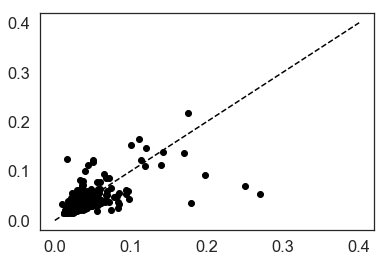

In [311]:
cell_passive = container_trial_mdf.groupby(['cell_specimen_id','passive']).mean_response.mean().unstack(level=1)
plt.plot(cell_passive.values[:,0],cell_passive.values[:,1],'ko')
plt.plot([0,0.4],[0,0.4],'k--')



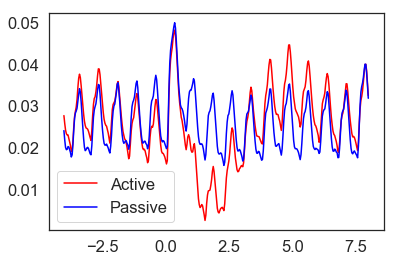

In [312]:
# plot the Average trace for all cells by active/passive
passive = container_trial_mdf.groupby('passive').mean_trace.apply(np.mean)
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
plt.plot(timestamps,passive.loc[False],'r',label='Active')
plt.plot(timestamps,passive.loc[True],'b',label='Passive')
plt.legend()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
**Exercise - Determine if each cell's preferred image is always the same on each session**    
</div>

In [330]:
# Solution
container_trial_mdf.reset_index().set_index(['cell_specimen_id','experiment_id','change_image_name'])['pref_stim'].unstack(level=-1).head()

change_image_name               im000  im031  im035  im045  im054  im061  \
cell_specimen_id experiment_id                                             
915019325        822024770        NaN    NaN    NaN    NaN    NaN  False   
                 822641265        NaN    NaN    NaN    NaN    NaN  False   
                 825120601      False   True  False  False  False    NaN   
                 825623170      False  False   True  False  False    NaN   
                 826585773      False  False  False   True  False    NaN   

change_image_name               im062  im063  im065  im066  im069  im073  \
cell_specimen_id experiment_id                                             
915019325        822024770      False   True  False  False  False    NaN   
                 822641265      False  False  False  False  False    NaN   
                 825120601        NaN    NaN    NaN    NaN    NaN  False   
                 825623170        NaN    NaN    NaN    NaN    NaN  False   
                 826585773        NaN    NaN    NaN    NaN    NaN  False   

change_image_name               im075  im077  im085  im106  
cell_specimen_id experiment_id                              
915019325        822024770        NaN  False  False    NaN  
                 822641265        NaN   True  False    NaN  
                 825120601      False    NaN    NaN  False  
                 825623170      False    NaN    NaN  False  
                 826585773      False    NaN    NaN  False